In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
import glob
from detectron2.data.datasets.coco import convert_to_coco_json

from vis import *
from dataset_bjtu import *

BASE_MODEL_101 = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
BASE_MODEL_50 = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"


In [3]:
register_coco_instances("bjtu_train_washed", {}, "BJTU_washed/train.json", ".")
register_coco_instances("bjtu_test_washed", {}, "BJTU_washed/test.json", ".")

In [4]:
import torch
from detectron2.engine import DefaultTrainer
print(torch.cuda.is_available())
print(torch.cuda.get_device_capability())
os.environ["CUDA_VISIBLE_DEVICES"] = "1,"

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    os.makedirs(cfg.EVAL_DIR, exist_ok=True)
    return COCOEvaluator(dataset_name, cfg, False, cfg.EVAL_DIR)


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file("config/baseline_s1000_washed.yaml")
if "WEIGHTS" not in cfg.MODEL:
  print("WEIGHTS not found in cfg.MODEL")
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.EVAL_DIR = os.path.join(cfg.OUTPUT_DIR, "coco_eval")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


True
(9, 0)


In [5]:
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

[06/18 22:20:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

WARNING [06/18 22:24:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 22:24:09 d2.data.datasets.coco]: Loaded 615 images in COCO format from BJTU_washed/train.json
[06/18 22:24:09 d2.data.build]: Removed 0 images with no usable annotations. 615 images left.
[06/18 22:24:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/18 22:24:09 d2.data.build]: Using training sampler TrainingSampler
[06/18 22:24:09 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/18 22:24:09 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[06/18 22:24:09 d2.data.common]: Serialized dataset takes 0.16 MiB
[06/18 22:24:09 d2.data.build]: Making batched data loader with batch_size=16


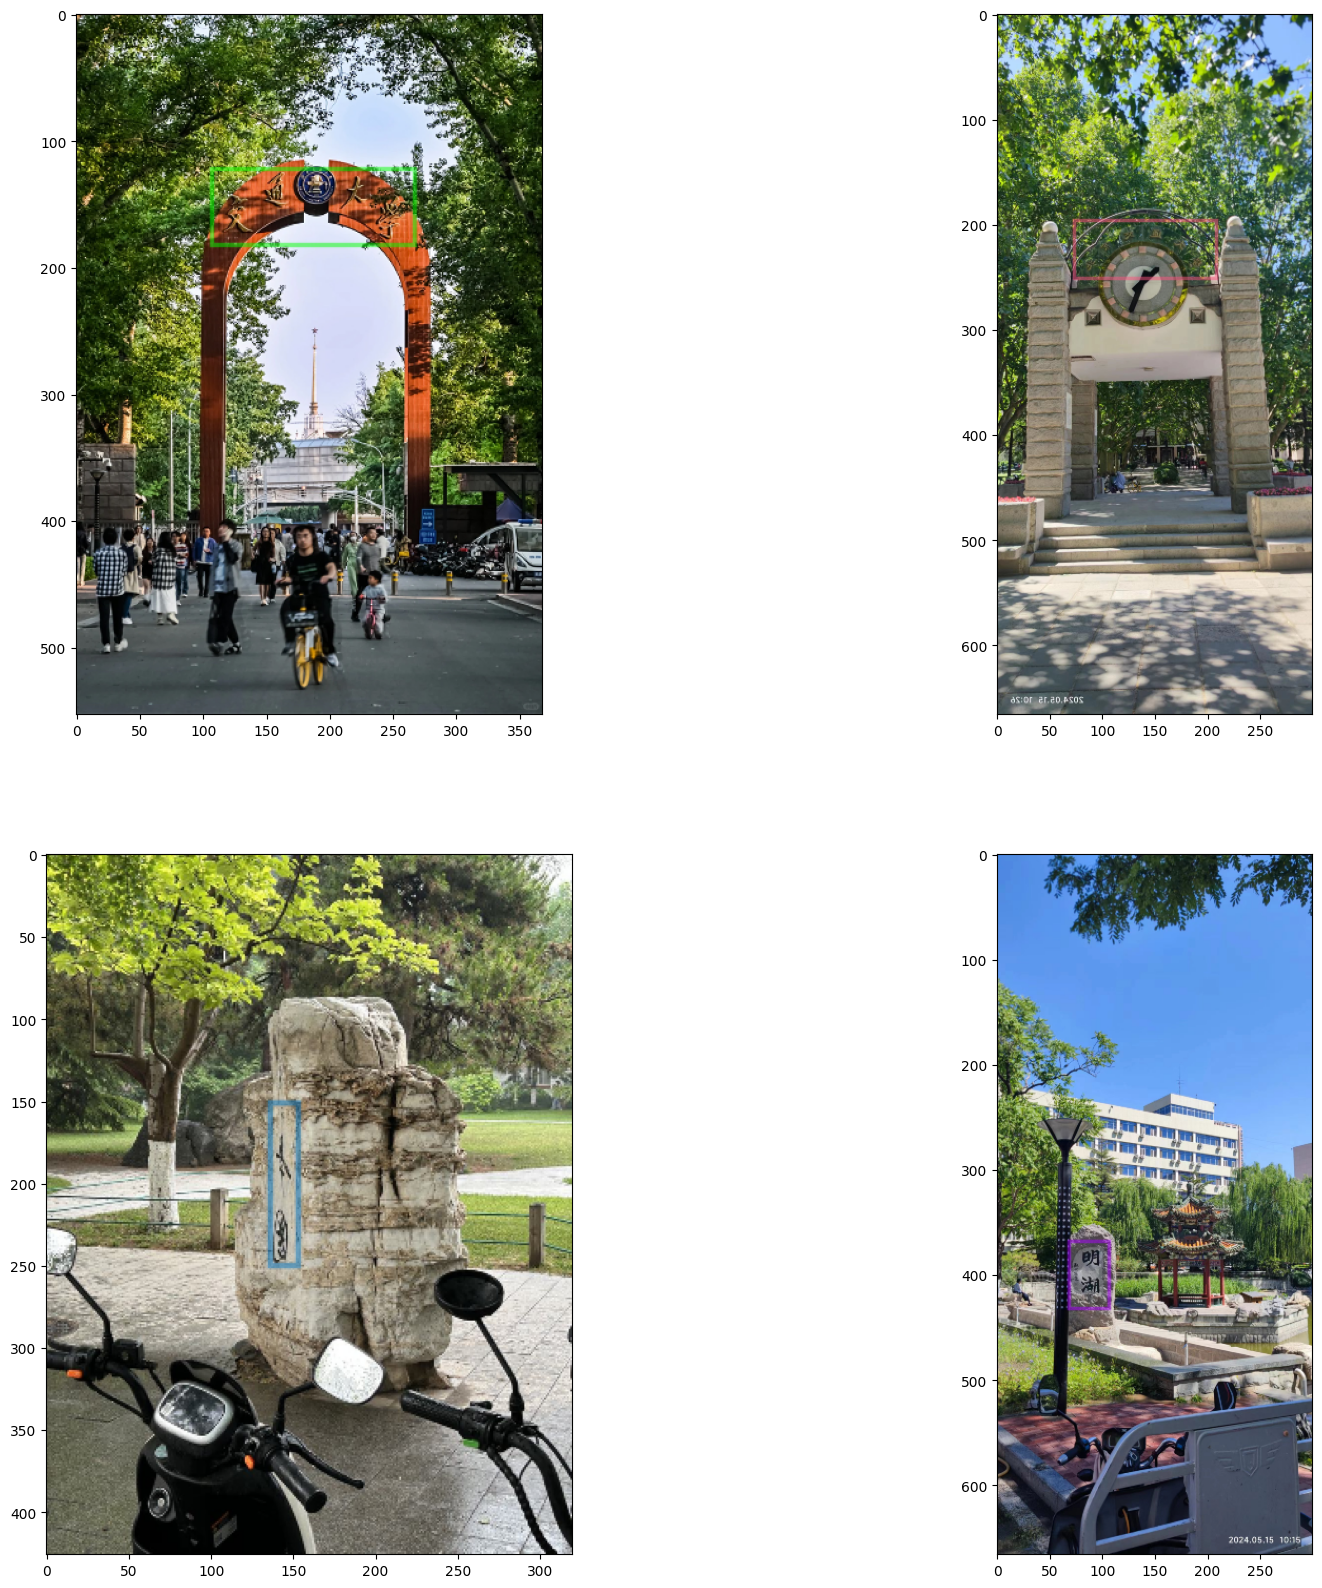

In [11]:
# 这个cell 显示训练中的图片

from detectron2.data import detection_utils as utils

train_data_loader = trainer.build_train_loader(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
data_iter = iter(train_data_loader)
batch = next(data_iter)
rows, cols = 2, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:4]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = utils.convert_image_to_rgb(img, "BGR")

    visualizer = Visualizer(img, metadata=metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    show_img = cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB) 
    
    plt.imshow(show_img)

In [9]:
''' 
Eval
'''

# dataset_dicts = get_bjtu_dicts(PATH_test)
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold


    
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

def eval(cfg, dataset, weight_dir=None, score=0.5):
    cfg = cfg.clone()
    if weight_dir is None:
        weight_dir = cfg.OUTPUT_DIR
    cfg.MODEL.WEIGHTS = os.path.join(weight_dir, "model_final.pth")
    predictor = DefaultPredictor(cfg)
    output_dir = os.path.join(weight_dir, "coco_eval")
    os.makedirs(output_dir, exist_ok=True)
    evaluator = COCOEvaluator(dataset, output_dir=output_dir)
    val_loader = build_detection_test_loader(cfg, dataset)
    print(inference_on_dataset(predictor.model, val_loader, evaluator))
    # another equivalent way to evaluate the model is to use `trainer.test`

eval(cfg, "bjtu_test_washed", "result/baseline_faster_r50_b16_s250_washed")

[06/18 19:20:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from result/baseline_faster_r50_b16_s250_washed/model_final.pth ...
WARNING [06/18 19:20:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 19:20:30 d2.data.datasets.coco]: Loaded 167 images in COCO format from BJTU_washed/test.json
[06/18 19:20:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/18 19:20:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/18 19:20:30 d2.data.common]: Serializing 167 elements to byte tensors and concatenating them all ...
[06/18 19:20:30 d2.data.common]: Serialized dataset takes 0.04 MiB
[06/18 19:20:30 d2.evaluation.evaluator]: Start inference on 167 batches
[06/18 19:20:31 d2.evaluation.evaluator]: Inference done 11/167. Da

In [ ]:
'''
Show single file
'''

def check_single(cfg, dataset, weight_dir=None, score=0.5):
    dataset_dicts = DatasetCatalog.get(dataset)
    cfg = cfg.clone()
    if weight_dir is None:
        weight_dir = cfg.OUTPUT_DIR
    cfg.MODEL.WEIGHTS = os.path.join(weight_dir, "model_final.pth")
    predictor = DefaultPredictor(cfg)
    outputs_list = []
    for d in random.sample(dataset_dicts, 20):  
        out_list = []
        print(d)  
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v1 = Visualizer(im[:, :, ::-1],
                    metadata=MetadataCatalog.get("bjtu_test"), 
                    scale=1, 
        )
        out = v1.draw_dataset_dict(d)
        out_list.append(out.get_image()[:, :, ::-1])
        v2 = Visualizer(im[:, :, ::-1],
                    metadata=MetadataCatalog.get("bjtu_test"), 
                    scale=1, 
        )
        out = v2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_list.append(out.get_image()[:, :, ::-1])
        out_list.append(im)
        outputs_list.append(out_list)
    return outputs_list
        
outputs = check_single(cfg, "bjtu_test")


WARNING [06/18 15:48:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/18 15:48:50 d2.data.datasets.coco]: Loaded 180 images in COCO format from BJTU/test.json


[06/18 15:48:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from result/baseline_faster_r50_b16_s250/model_final.pth ...
{'file_name': './BJTU/test/sy-uu77v.png', 'height': 768, 'width': 576, 'image_id': 123, 'annotations': [{'iscrowd': 0, 'bbox': [162.0, 59.0, 228.0, 39.0], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
{'file_name': './BJTU/test/mh-pofaad54610001.jpg', 'height': 768, 'width': 1024, 'image_id': 47, 'annotations': [{'iscrowd': 0, 'bbox': [665.0, 244.0, 66.0, 194.0], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
{'file_name': './BJTU/test/sjz-4684144sada.jpg', 'height': 891, 'width': 668, 'image_id': 78, 'annotations': [{'iscrowd': 0, 'bbox': [150.0, 228.0, 342.0, 158.0], 'category_id': 0, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}
{'file_name': './BJTU/test/fhy-fgduhggdtrsehj67fdgfjf.jpg', 'height': 667, 'width': 1000, 'image_id': 15, 'annotations': [{'iscrowd': 0, 'bbox': [617.0, 208.0, 86.0, 270.0], 'category_id': 1, 'bbox_mode'

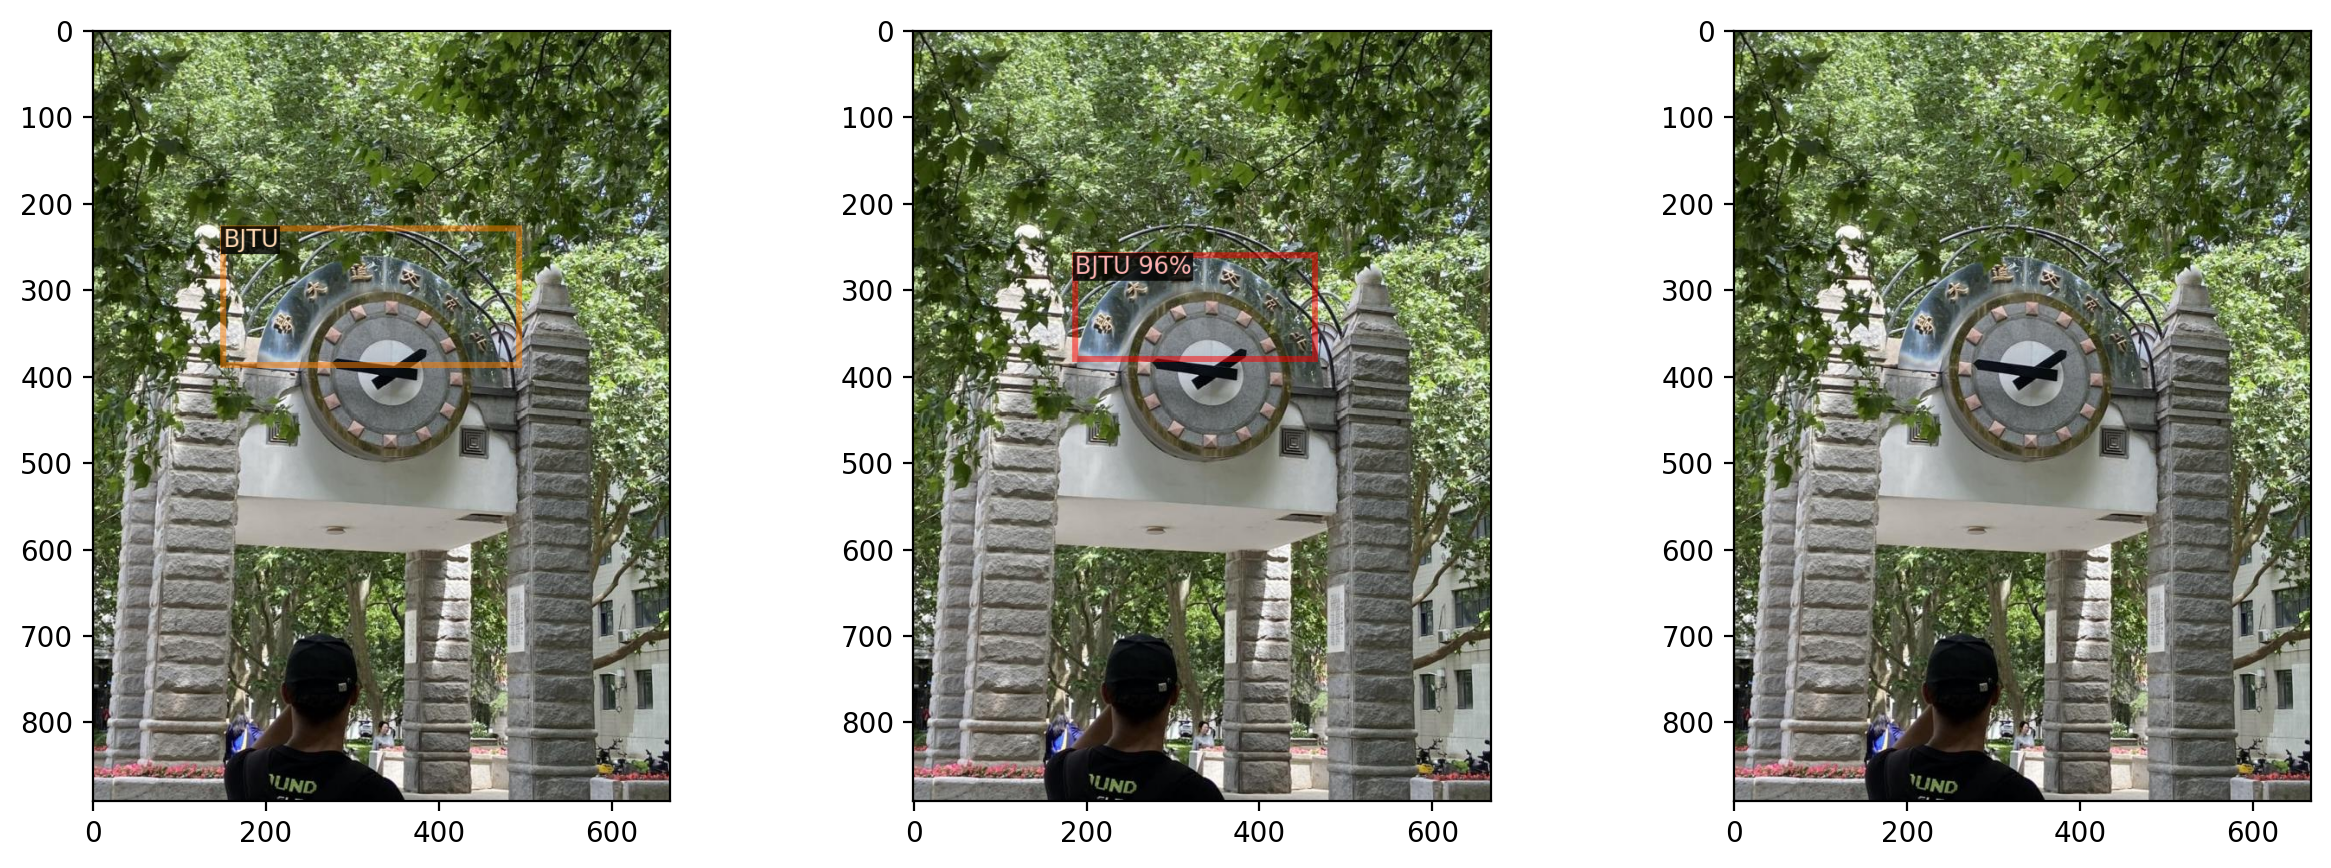

In [ ]:

def show_batch(output, index):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, ax in enumerate(axs):
        show_img = output[index][i]
        show_img = cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB)
        # ax.axis('off')
        ax.imshow(show_img)
    plt.show()

show_batch(outputs, 2)




# Dataset
